# Разведывательный анализ данных учащихся

## Цель проекта:
Отследить **влияние условий жизни** учащихся в возрасте от 15 до 22 лет **на их успеваемость по математике**, что позволит на ранней стадии выявлять студентов, находящихся в группе риска.

## Задачи проекта:
1. Провести **разведывательный анализ данных (EDA)**:
    - _проверить качество данных_ и очистить их при необходимости;
    - _сформулировать предположения_ для дальнейшего построения модели;
    - _определиться с параметрами модели_, оказывающими влияние на целевой показатель (успеваемость по математике).
2. Построить модель, предсказывающую результаты госэкзамена по математике для каждого ученика школы.

В рамках данного подпроекта решалась только **первая задача**. 

## Первичный осмотр данных

In [1]:
# Импортируем библиотеки
import pandas as pd
import numpy as np
import math 

import matplotlib.pyplot as plt
import seaborn as sns

from itertools import combinations
from scipy.stats import ttest_ind
from scipy.stats import norm
from random import random

import mod_eda # импортируем модуль с созданными функциями проведения EDA

# Настроим вывод графиков и таблиц
sns.set()

pd.set_option('display.max_rows', 50) # выведем больше строк
pd.set_option('display.max_columns', 50) # выведем больше колонок

In [2]:
# Загрузим исходный датасет и рассмотрим его
stud = pd.read_csv('stud_math.csv')
display(stud.head(10))
stud.info()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,"studytime, granular",higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 395 entries, 0 to 394
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   school               395 non-null    object 
 1   sex                  395 non-null    object 
 2   age                  395 non-null    int64  
 3   address              378 non-null    object 
 4   famsize              368 non-null    object 
 5   Pstatus              350 non-null    object 
 6   Medu                 392 non-null    float64
 7   Fedu                 371 non-null    float64
 8   Mjob                 376 non-null    object 
 9   Fjob                 359 non-null    object 
 10  reason               378 non-null    object 
 11  guardian             364 non-null    object 
 12  traveltime           367 non-null    float64
 13  studytime            388 non-null    float64
 14  failures             373 non-null    float64
 15  schoolsup            386 non-null    obj

Первичный осмотр данных позволяет сделать вывод о том, что только *первые 3 колонки без пропусков*: "school", "sex", "age". 

В распоряжении имеются *30* колонок, из них *13* - **условно числовых** (хотя истинно **числовых** только *4*: "age", "absences", "score" и "studytime, granular", остальные **ранговые**), *17* - **категориальных** (*8* из них потенциально можно превратить в бинарный тип).  

Также первичный осмотр данных показал, что часть колонок названы с большой буквы (с целью отделения одного слова от другого). Есть также одна колонка "studytime, granular" имеющая название, написанное через запятую. 

Приведём колонки к стилю написания с маленькой буквы с отделением слов подчёркиванием.

In [3]:
stud.columns = ['school', 'sex', 'age', 'adress', 'famsize', 'p_status', 'm_edu', 'f_edu',
                'm_job', 'f_job', 'reason', 'guardian', 'traveltime', 'studytime',
                'failures', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery',
                'studytime_granular', 'higher', 'internet', 'romantic', 'famrel',
                'freetime', 'goout', 'health', 'absences', 'score']
display(stud.head(10))

,school,sex,age,adress,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
0,GP,F,18,U,NaN,A,4.0,4.0,at_home,teacher,course,mother,2.0,2.0,0.0,yes,no,no,no,yes,-6.0,yes,NaN,no,4.0,3.0,4.0,3.0,6.0,30.0
1,GP,F,17,U,GT3,NaN,1.0,1.0,at_home,other,course,father,1.0,2.0,0.0,no,yes,no,no,no,-6.0,yes,yes,no,5.0,3.0,3.0,3.0,4.0,30.0
2,GP,F,15,U,LE3,T,1.0,1.0,at_home,other,other,mother,1.0,2.0,3.0,yes,no,NaN,no,yes,-6.0,yes,yes,NaN,4.0,3.0,2.0,3.0,10.0,50.0
3,GP,F,15,U,GT3,T,4.0,2.0,health,NaN,home,mother,1.0,3.0,0.0,no,yes,yes,yes,yes,-9.0,yes,yes,yes,3.0,2.0,2.0,5.0,2.0,75.0
4,GP,F,16,U,GT3,T,3.0,3.0,other,other,home,father,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,no,no,4.0,3.0,2.0,5.0,4.0,50.0
5,GP,M,16,U,LE3,T,4.0,3.0,services,other,reputation,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,4.0,2.0,5.0,10.0,75.0
6,GP,M,16,NaN,LE3,T,2.0,2.0,other,other,home,mother,1.0,2.0,0.0,no,no,no,no,yes,-6.0,yes,yes,no,4.0,4.0,4.0,3.0,0.0,55.0
7,GP,F,17,U,GT3,A,4.0,4.0,other,teacher,home,mother,2.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,4.0,1.0,4.0,1.0,6.0,30.0
8,GP,M,15,U,LE3,A,3.0,2.0,services,other,home,mother,1.0,2.0,0.0,no,yes,yes,no,yes,-6.0,yes,yes,no,NaN,2.0,2.0,1.0,0.0,95.0
9,GP,M,15,U,NaN,NaN,3.0,4.0,other,other,home,mother,1.0,2.0,0.0,no,yes,yes,yes,yes,-6.0,yes,yes,no,5.0,5.0,1.0,5.0,0.0,75.0


### Описание колонок:
1 **school** — аббревиатура школы, в которой учится ученик;

2 **sex** — пол ученика (**'F'** - женский, **'M'** - мужской);

3 **age** — возраст ученика (от **15** до **22**);

4 **address** — тип адреса ученика (**'U'** - городской, **'R'** - за городом);

5 **famsize** — размер семьи(**'LE3'** <= 3, **'GT3'** >3);

6 **p_status** — статус совместного жилья родителей (**'T'** - живут вместе **'A'** - раздельно);

7 **m_edu** — образование матери (**0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее);

8 **f_edu** — образование отца (**0** - нет, **1** - 4 класса, **2** - 5-9 классы, 
    **3** - среднее специальное или 11 классов, **4** - высшее);

9 **m_job** — работа матери (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

10 **f_job** — работа отца (**'teacher'** - учитель, **'health'** - сфера здравоохранения, 
    **'services'** - гос служба, **'at_home'** - не работает, **'other'** - другое);

11 **reason** — причина выбора школы (**'home'** - близость к дому, **'reputation'** - репутация школы, 
    **'course'** - образовательная программа, **'other'** - другое);

12 **guardian** — опекун (**'mother'** - мать, **'father'** - отец, **'other'** - другое);

13 **traveltime** — время в пути до школы (**1** - <15 мин., **2** - 15-30 мин., 
    **3** - 30-60 мин., **4** - >60 мин.);

14 **studytime** — время на учёбу помимо школы в неделю (**1** - <2 часов, **2** - 2-5 часов, 
    **3** - 5-10 часов, **4** - >10 часов);

15 **failures** — количество внеучебных неудач (**n**, если 1<=n<3, иначе **4**);

16 **schoolsup** — дополнительная образовательная поддержка (**yes** или **no**);

17 **famsup** — семейная образовательная поддержка (**yes** или **no**);

18 **paid** — дополнительные платные занятия по математике (**yes** или **no**);

19 **activities** — дополнительные внеучебные занятия (**yes** или **no**);

20 **nursery** — посещал детский сад (**yes** или **no**);

**studytime_granular** - неизвестная колонка, необходимо понять, с чем она коррелирует

21 **higher** — хочет получить высшее образование (**yes** или **no**);

22 **internet** — наличие интернета дома (**yes** или **no**);

23 **romantic** — в романтических отношениях (**yes** или **no**);

24 **famrel** — семейные отношения (от **1** - очень плохо до **5** - очень хорошо);

25 **freetime** — свободное время после школы (от **1** - очень мало до **5** - очень мого);

26 **goout** — проведение времени с друзьями (от **1** - очень мало до **5** - очень много);

27 **health** — текущее состояние здоровья (от **1** - очень плохо до **5** - очень хорошо);

28 **absences** — количество пропущенных занятий;

29 **score** — баллы по госэкзамену по математике (целевой параметр).


## Первичный анализ данных в столбцах

### school
Аббревиатура школы, в которой учится ученик.

Состав колонки school


,total,proportion
GP,349,0.883544
MS,46,0.116456



 None-значения отсутствуют. Пробельные пропуски отсутствуют.

Общий размер выборки студентов: 395


(array([0, 1]), <a list of 2 Text xticklabel objects>)

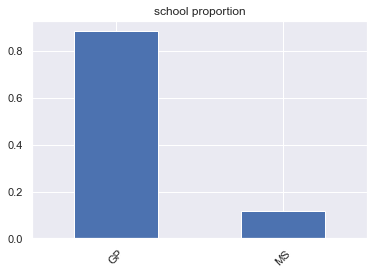

In [4]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'school'

# Оценим состав данной колонки
print('Состав колонки', column)
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

#Имеются ли None-элементы или пробельные пропуски
print('\n', mod_eda.find_nulls(stud[column])[0])

# Определим размер выборки студентов
stud_count_total = stud[column].value_counts().sum()
print('\nОбщий размер выборки студентов:', stud_count_total)

#Построим распределение
stud[column].value_counts(normalize=True).plot(kind='bar',
                                                grid= True,
                                                title=column + " proportion",
                                                legend=False) 
plt.xticks(rotation=45) # Учебный комментарий: пробелы вокруг "=" для именнованного аргумента не ставятся (pep-8)

**Вывод по столбцу 'school'**: Пропуски в данном столбце отсутствуют. Около *88%* студентов выборки (общим размером *395* человек) обучаются в школе **"GP"**.  

### sex
Пол ученика: 'F' - женский, 'M' - мужской

Состав колонки sex


,total,proportion
F,208,0.526582
M,187,0.473418



 None-значения отсутствуют. Пробельные пропуски отсутствуют.


(array([0, 1]), <a list of 2 Text xticklabel objects>)

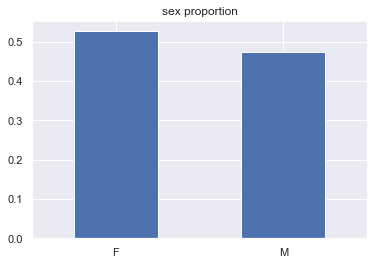

In [5]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'sex'

# Оценим состав данной колонки
print('Состав колонки', column)
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

#Имеются ли None-элементы или пробельные пропуски
print('\n', mod_eda.find_nulls(stud[column])[0])

#Построим распределение
stud[column].value_counts(normalize=True).plot(kind='bar',
                                                grid= True,
                                                title=column + " proportion",
                                                legend=False)
plt.xticks(rotation = 0) 

**Вывод по столбцу 'sex'**: В данном столбце пропусков нет. Имеется небольшой **перевес**, порядка 5% **в пользу количества девочек** в выборке.

### age
Возраст ученика (от 15 до 22)

Статистические характеристики колонки age


count    395.000000
mean      16.696203
std        1.276043
min       15.000000
25%       16.000000
50%       17.000000
75%       18.000000
max       22.000000
Name: age, dtype: float64


 None-значения отсутствуют. Пробельные пропуски отсутствуют.


Text(0.5, 1.0, 'age boxplot')

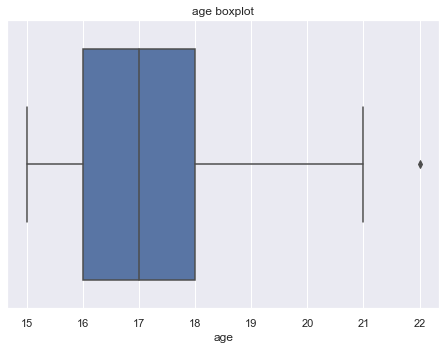

In [6]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ ЧИСЛОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'age'

# Статистическое описание колонки
print('Статистические характеристики колонки', column)
display(stud[column].describe())

#Имеются ли None-элементы или пробельные пропуски
print('\n', mod_eda.find_nulls(stud[column])[0])

#Построим boxplot
fig = plt.figure()
axes = fig.add_axes([0, 0, 1, 1])
sns.boxplot(stud[column],ax=axes)
axes.set_title(column+' boxplot') 

Присутствуют выбросы, вычислим границы выбросов.

Значения выбросов и их количество


,outliers_count
22,1


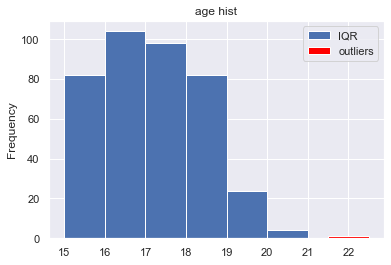

In [7]:
# РАСПРЕДЕЛЕНИЕ ЧИСЛОВОГО ПРИЗНАКА
# Определим границы выбросов, и выведем данные, соответствующие этому диапазону в гистограмму
boards = mod_eda.get_boards(stud[column])

# Выведем значение и количество выбросов
print('Значения выбросов и их количество')
display(pd.DataFrame({'outliers_count': stud[(stud[column] > boards[1])|
                        (stud[column] < boards[0])][column].value_counts()}))

# Посмотрим распределение признака
stud[stud[column].between(boards[0], boards[1])][column].plot(kind='hist',bins=6, label = 'IQR', title=column+' hist') # Значения без выбросов
stud[(stud[column] > boards[1])|(stud[column] < boards[0])][column].plot(kind='hist', bins = 1, color = 'red', label = 'outliers') # Выбросы

plt.legend()

**Вывод по столбцу 'age'**: В данном столбце отсутствуют пропуски. Возраст студентов имеет близкое к нормальному распределение. Имеется один **выброс - 22 года**

### adress
Тип адреса ученика: **'U'** - городской, **'R'** - за городом.

Состав колонки adress


,total,proportion
U,295,0.780423
R,83,0.219577



 17 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 4.3%


(array([0, 1]), <a list of 2 Text xticklabel objects>)

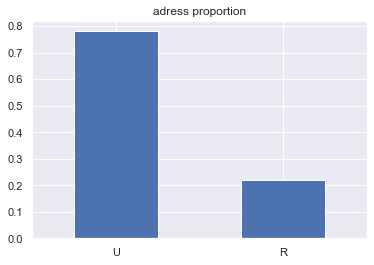

In [8]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'adress'

# Оценим состав данной колонки
print('Состав колонки', column)
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

# Имеются ли None-элементы или пробельные пропуски
nulls_list = mod_eda.find_nulls(stud[column])
print('\n', nulls_list[0])

# Оценим процентное содержание пропусков
nulls_sum = nulls_list[1] + nulls_list[2]
if nulls_sum > 0:
    print(f'Доля пропусков от объёма выборки: {round(nulls_sum/stud_count_total*100, 1)}%')

# Построим распределение
stud[column].value_counts(normalize=True).plot(kind='bar',
                                                grid= True,
                                                title=column + " proportion",
                                                legend=False)
plt.xticks(rotation = 0) 

### Варианты [заполнения пропусков](https://gallery.azure.ai/Experiment/Methods-for-handling-missing-values-1):
- помещение пропусков в **отдельную группу**, например со значением "0" (*положим, что этот метод актуален при доле пропусков больше **15-20%** *);
- замена пропусков **мерами центра**: модой, медианой, средним и т.д.;
- замена **на соседнее** значение;
- **интерполяция** значений *(актуально для временных рядов)*;
- создание **отдельного столбца с bool-типом** для отслеживания какие 
значения присутствовали в исходном датасете, а какие были искусственно введены.
Применяется при *большом количестве пропусков*;
- учёт уже имеющейся в колонке пропорции между дискретными значениями;
- применение метода **"приписывания"** (*Imputation method*), подразумевающего наличие взаимосвязи значений рассматриваемого столбца с другими, на основе которой можно предположить, какое значение могло быть вместо пропуска. Особенно актуально применение данного метода при наличии корреляции данной колонки
с другой.

Для реализации последних двух методов: **учёта пропорции** в колонке и метода **"приписывания"** была написана функция mod_eda.**fill_rand**(main_series, *sub_series=pd.Series([])*): 
- Если подать на вход в неё только одну колонку, то она заполнит имеющиеся в ней пропуски на основе определённой пропорции между значениями. *Реализовано на генераторе случайных чисел и сопоставлении случайного числа с неравенствами, имеющими тем больший размах, чем больше пропорция для рассматриваемого значения. При попадании случайного числа в определённый интервал, рассматриваемый пропуск заполняется значением, соответствующим этому интервалу*.
- При подаче дополнительной колонки на вход функции, расчёт распределения вероятностей ведётся по теореме [Томаса Байеса](https://ru.wikipedia.org/wiki/%D0%A2%D0%B5%D0%BE%D1%80%D0%B5%D0%BC%D0%B0_%D0%91%D0%B0%D0%B9%D0%B5%D1%81%D0%B0):
$$p(H_i|A) = \frac{p(H_i)*p(A|H_i)}{p(A)}, $$
где $p(H_i|A)$ - искомая апостериорная вероятность (после опыта) гипотезы $H_i$ при наступлении события $A$;
$p(H_i)$ - априорная вероятность гипотезы (то есть до опыта);
$p(A|H_i)$ - вероятность наступления события $A$ при истинности гипотезы $H_i$;
$p(A)$ - полная вероятность наступления события $A$.

Для начала реализуем метод **"приписывания"** вручную, а затем сопоставим результат с работой написанной функции.
Найдём ту колонку, которая, исходя из логических соображений, может коррелировать с рассматриваемой. Для числовых колонок можно находить корреляцию посредством функции **.corr()**, применяемой к датафрейму.

Найдём колонку, наиболее сильно коррелирующую с колонкой **'adress'**

In [9]:
temp = stud.copy(deep=True) # Копирование датафрейма без зависимости
# Временно, для грубой оценки зависимости, приведём столбец "adress" к числовому виду
temp['adress'] = temp['adress'].apply(lambda x: 1 if str(x) == 'U' else 0 if str(x) == 'R' else None)
temp.corr()['adress']

age                  -0.147902
adress                1.000000
m_edu                 0.153189
f_edu                 0.065295
traveltime           -0.285782
studytime            -0.045182
failures             -0.101835
studytime_granular    0.045182
famrel               -0.017216
freetime              0.055708
goout                 0.063285
health               -0.049985
absences              0.025661
score                 0.120067
Name: adress, dtype: float64

Анализ показал, что предположительно имеется связь между **"adress" и "traveltime"** (типом адреса ученика и временем, затрачиваемым на дорогу). **Предполагается**, что при большом времени в пути ученик живёт за городом.

Проверим статистическую значимость взаимосвязи этих колонок.

#### Для решения этой задачи была написана функция нахождения колонок, имеющих статистически значимую взаимосвязь с изучаемой
**Идея:** найти те колонки, в которых расхождение в распределении значений по параметрам исследуемой колонки имеет статистическую значимость.

Данная идея была реализована посредством написанной функции mod_eda.**get_col_depend**(...)

In [10]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
# Получение списка колонок для анализа (c удалением изучаемой колонки)
col_list = list(stud.columns)
col_list.remove(column)

# Вывод колонок, имеющих статистически значимую взаимосвязь
all_col = [] # Вывод всех данных для дополнительной обработки
col_depend = []
for sub_column in col_list:
    cur_res = mod_eda.get_col_depend(stud.reset_index(), column, sub_column, 'index')
    all_col.append(cur_res)
    if float(cur_res[1]) > 0: # Если есть взаимосвязь
        col_depend.append(cur_res[2])
print('\n'.join(col_depend))

Обнаружена статистически значимая связь между "school" и "adress",	 log10(alpha/p_value) = 6.952
Обнаружена статистически значимая связь между "age" и "adress",	 log10(alpha/p_value) = 1.659
Обнаружена статистически значимая связь между "m_edu" и "adress",	 log10(alpha/p_value) = 2.589
Обнаружена статистически значимая связь между "m_job" и "adress",	 log10(alpha/p_value) = 1.496
Обнаружена статистически значимая связь между "reason" и "adress",	 log10(alpha/p_value) = 1.279
Обнаружена статистически значимая связь между "traveltime" и "adress",	 log10(alpha/p_value) = 1.77
Обнаружена статистически значимая связь между "studytime" и "adress",	 log10(alpha/p_value) = 1.041
Обнаружена статистически значимая связь между "failures" и "adress",	 log10(alpha/p_value) = 0.794
Обнаружена статистически значимая связь между "studytime_granular" и "adress",	 log10(alpha/p_value) = 1.041
Обнаружена статистически значимая связь между "internet" и "adress",	 log10(alpha/p_value) = 3.31
Обнаружена ста

Тестирование гипотез о разности выборочных пропорций показало, что есть статистически значимая взаимосвязь между "adress" и "school", "internet", "m_edu", "traveltime"

In [11]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ ДВУМЯ КОЛОНКАМИ
sub_column = 'school'

# Рассмотрим распределение значений:
print(f'Распределение значений колонки {sub_column} по значениям колонки {column}')
display(pd.crosstab(stud[column],stud[sub_column],normalize='columns'))

# Какое количество строк с пропусками в обеих колонках
print('\nКоличество строк с пропусками в обеих колонках:', len(stud[(stud[column].isna())&(stud[sub_column].isna())]))

# Оценим состав среди None в изучаемой колонки
print('\nСостав для None-значений изучаемой колонки')
display(stud[stud[column].isna()][sub_column].value_counts(normalize=True))

# Повтор пропорции
print('\nПропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Распределение значений колонки school по значениям колонки adress


school,GP,MS
adress,,
R,0.178042,0.560976
U,0.821958,0.439024



Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки


GP    0.705882
MS    0.294118
Name: school, dtype: float64


Пропорция изучаемой колонки


,total,proportion
U,295,0.780423
R,83,0.219577


Заполним пропуски функцией mod_eda.**fill_rand**.

In [12]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'school'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

print('Имеются ли пропуски:', stud[column].isna().value_counts())

# Оценим новый состав данной колонки
print('\nНовая пропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Имеются ли пропуски: False    395
Name: adress, dtype: int64

Новая пропорция изучаемой колонки


,total,proportion
U,309,0.782278
R,86,0.217722


Заполнение функцией mod_eda.**fill_rand** дало пропорцию между значениями более близкую к изначальной c расхождением в 1%.

**Вывод по столбцу 'adress'**: Таким образом, **17** пропущенных значений колонки **adress** были заполнены методом **приписывания**, то есть с учётом данных в других колонках. Наиболее ярко выраженная статистически значимая связь между **"school"** и **"adress"**

Около 78% учеников **живёт в городе**.

### famsize
Размер семьи: 'LE3' <= 3, 'GT3' >3

Состав колонки famsize


,total,proportion
GT3,261,0.709239
LE3,107,0.290761



 27 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 6.8%


(array([0, 1]), <a list of 2 Text xticklabel objects>)

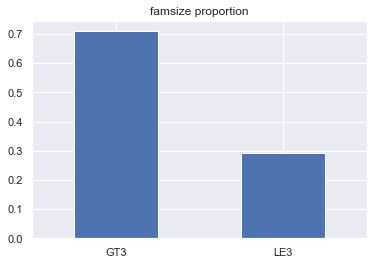

In [13]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'famsize'

# Оценим состав данной колонки
print('Состав колонки', column)
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

# Имеются ли None-элементы или пробельные пропуски
nulls_list = mod_eda.find_nulls(stud[column])
print('\n', nulls_list[0])

# Оценим процентное содержание пропусков
nulls_sum = nulls_list[1] + nulls_list[2]
if nulls_sum > 0:
    print(f'Доля пропусков от объёма выборки: {round(nulls_sum/stud_count_total*100, 1)}%')

# Построим распределение
stud[column].value_counts(normalize=True).plot(kind='bar',
                                            grid= True,
                                            title=column + " proportion",
                                            legend=False)
plt.xticks(rotation = 0) 

Найдём колонки со статистически значимой взаимосвязью.

In [14]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
# Получение списка колонок для анализа (c удалением изучаемой колонки)
col_list = list(stud.columns)
col_list.remove(column)

# Вывод колонок, имеющих статистически значимую взаимосвязь
all_col = [] # Вывод всех данных для дополнительной обработки
col_depend = []
for sub_column in col_list:
    cur_res = mod_eda.get_col_depend(stud.reset_index(), column, sub_column, 'index')
    all_col.append(cur_res)
    if float(cur_res[1]) > 0: # Если есть взаимосвязь
        col_depend.append(cur_res[2])
print('\n'.join(col_depend))

Обнаружена статистически значимая связь между "sex" и "famsize",	 log10(alpha/p_value) = 0.548
Обнаружена статистически значимая связь между "p_status" и "famsize",	 log10(alpha/p_value) = 0.113
Обнаружена статистически значимая связь между "studytime" и "famsize",	 log10(alpha/p_value) = 1.637
Обнаружена статистически значимая связь между "famsup" и "famsize",	 log10(alpha/p_value) = 0.907
Обнаружена статистически значимая связь между "paid" и "famsize",	 log10(alpha/p_value) = 0.187
Обнаружена статистически значимая связь между "nursery" и "famsize",	 log10(alpha/p_value) = 0.593
Обнаружена статистически значимая связь между "studytime_granular" и "famsize",	 log10(alpha/p_value) = 0.795


Рассмотрим взаимосвязь "studytime" и "famsize", имеющую наибольшее отношение alpha/p_value.

In [15]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ ДВУМЯ КОЛОНКАМИ
sub_column = 'studytime'

# Рассмотрим распределение значений:
print(f'Распределение значений колонки {sub_column} по значениям колонки {column}')
display(pd.crosstab(stud[column],stud[sub_column],normalize='columns'))

# Какое количество строк с пропусками в обеих колонках
print('\nКоличество строк с пропусками в обеих колонках:', len(stud[(stud[column].isna())&(stud[sub_column].isna())]))

# Оценим состав среди None в изучаемой колонки
print('\nСостав для None-значений изучаемой колонки')
display(stud[stud[column].isna()][sub_column].value_counts(normalize=True))

# Повтор пропорции
print('\nПропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Распределение значений колонки studytime по значениям колонки famsize


studytime,1.0,2.0,3.0,4.0
famsize,,,,
GT3,0.684211,0.662983,0.883333,0.692308
LE3,0.315789,0.337017,0.116667,0.307692



Количество строк с пропусками в обеих колонках: 1

Состав для None-значений изучаемой колонки


2.0    0.500000
1.0    0.307692
3.0    0.153846
4.0    0.038462
Name: studytime, dtype: float64


Пропорция изучаемой колонки


,total,proportion
GT3,261,0.709239
LE3,107,0.290761


Рассмотрим взаимосвязь "famsup" и "famsize".

In [16]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ ДВУМЯ КОЛОНКАМИ
sub_column = 'famsup'

# Рассмотрим распределение значений:
print(f'Распределение значений колонки {sub_column} по значениям колонки {column}')
display(pd.crosstab(stud[column],stud[sub_column],normalize='columns'))

# Какое количество строк с пропусками в обеих колонках
print('\nКоличество строк с пропусками в обеих колонках:', len(stud[(stud[column].isna())&(stud[sub_column].isna())]))

# Оценим состав среди None в изучаемой колонки
print('\nСостав для None-значений изучаемой колонки')
display(stud[stud[column].isna()][sub_column].value_counts(normalize=True))

# Повтор пропорции
print('\nПропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Распределение значений колонки famsup по значениям колонки famsize


famsup,no,yes
famsize,,
GT3,0.645669,0.759615
LE3,0.354331,0.240385



Количество строк с пропусками в обеих колонках: 6

Состав для None-значений изучаемой колонки


yes    0.52381
no     0.47619
Name: famsup, dtype: float64


Пропорция изучаемой колонки


,total,proportion
GT3,261,0.709239
LE3,107,0.290761


Ввиду того, что количество строк с пропусками в обеих колонках меньше в первом варианте, а также alpha/p_value максимально, заполним с помощью колонки **'studytime'**

In [17]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'studytime'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

print('Имеются ли пропуски:', stud[column].isna().value_counts())

# Оценим новый состав данной колонки
print('\nНовая пропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Имеются ли пропуски: False    395
Name: famsize, dtype: int64

Новая пропорция изучаемой колонки


,total,proportion
GT3,280,0.708861
LE3,115,0.291139


**Вывод по столбцу 'famsize'**: **27** пропущенных значений колонки **famsize** были заполнены методом **приписывания**. Наиболее сильная статистически значимая связь между **"studytime"** и **"famsize"**.

Около 70% учеников живёт в семье с размером семьи **больше 3х человек**.

### **p_status**
Cтатус совместного жилья родителей: **'T'** - живут вместе, **'A'** - раздельно.

Состав колонки p_status


,total,proportion
T,314,0.897143
A,36,0.102857



 45 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 11.4%


(array([0, 1]), <a list of 2 Text xticklabel objects>)

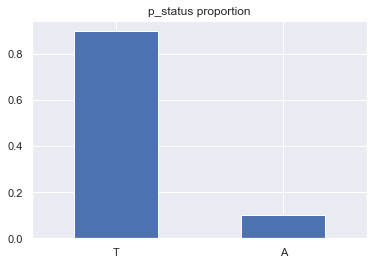

In [18]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ КАТЕГОРИАЛЬНОЙ КОЛОНКИ
# Интересующая колонка
column = 'p_status'

# Оценим состав данной колонки
print('Состав колонки', column)
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

# Имеются ли None-элементы или пробельные пропуски
nulls_list = mod_eda.find_nulls(stud[column])
print('\n', nulls_list[0])

# Оценим процентное содержание пропусков
nulls_sum = nulls_list[1] + nulls_list[2]
if nulls_sum > 0:
    print(f'Доля пропусков от объёма выборки: {round(nulls_sum/stud_count_total*100, 1)}%')

# Построим распределение
stud[column].value_counts(normalize=True).plot(kind='bar',
                                            grid= True,
                                            title=column + " proportion",
                                            legend=False)
plt.xticks(rotation = 0) 

Найдём колонки со статистически значимой связью.

In [19]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
# Получение списка колонок для анализа (c удалением изучаемой колонки)
col_list = list(stud.columns)
col_list.remove(column)

# Вывод колонок, имеющих статистически значимую взаимосвязь
all_col = [] # Вывод всех данных для дополнительной обработки
col_depend = []
for sub_column in col_list:
    cur_res = mod_eda.get_col_depend(stud.reset_index(), column, sub_column, 'index')
    all_col.append(cur_res)
    if float(cur_res[1]) > 0: # Если есть взаимосвязь
        col_depend.append(cur_res[2])
print('\n'.join(col_depend))

Обнаружена статистически значимая связь между "famsize" и "p_status",	 log10(alpha/p_value) = 0.131
Обнаружена статистически значимая связь между "m_edu" и "p_status",	 log10(alpha/p_value) = 1.445
Обнаружена статистически значимая связь между "activities" и "p_status",	 log10(alpha/p_value) = 0.56


Рассмотрим взаимосвязь "m_edu" и "p_status".

In [20]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ ДВУМЯ КОЛОНКАМИ
sub_column = 'm_edu'

# Рассмотрим распределение значений:
print(f'Распределение значений колонки {sub_column} по значениям колонки {column}')
display(pd.crosstab(stud[column],stud[sub_column],normalize='columns'))

# Какое количество строк с пропусками в обеих колонках
print('\nКоличество строк с пропусками в обеих колонках:', len(stud[(stud[column].isna())&(stud[sub_column].isna())]))

# Оценим состав среди None в изучаемой колонки
print('\nСостав для None-значений изучаемой колонки')
display(stud[stud[column].isna()][sub_column].value_counts(normalize=True))

# Повтор пропорции
print('\nПропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Распределение значений колонки m_edu по значениям колонки p_status


m_edu,0.0,1.0,2.0,3.0,4.0
p_status,,,,,
A,0.0,0.019231,0.066667,0.168675,0.123967
T,1.0,0.980769,0.933333,0.831325,0.876033



Количество строк с пропусками в обеих колонках: 2

Состав для None-значений изучаемой колонки


3.0    0.325581
2.0    0.279070
4.0    0.232558
1.0    0.162791
Name: m_edu, dtype: float64


Пропорция изучаемой колонки


,total,proportion
T,314,0.897143
A,36,0.102857


Рассмотрим взаимосвязь "activities" и "p_status".

In [21]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ ДВУМЯ КОЛОНКАМИ
sub_column = 'activities'

# Рассмотрим распределение значений:
print(f'Распределение значений колонки {sub_column} по значениям колонки {column}')
display(pd.crosstab(stud[column],stud[sub_column],normalize='columns'))

# Какое количество строк с пропусками в обеих колонках
print('\nКоличество строк с пропусками в обеих колонках:', len(stud[(stud[column].isna())&(stud[sub_column].isna())]))

# Оценим состав среди None в изучаемой колонки
print('\nСостав для None-значений изучаемой колонки')
display(stud[stud[column].isna()][sub_column].value_counts(normalize=True))

# Повтор пропорции
print('\nПропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Распределение значений колонки activities по значениям колонки p_status


activities,no,yes
p_status,,
A,0.13253,0.069767
T,0.86747,0.930233



Количество строк с пропусками в обеих колонках: 2

Состав для None-значений изучаемой колонки


yes    0.534884
no     0.465116
Name: activities, dtype: float64


Пропорция изучаемой колонки


,total,proportion
T,314,0.897143
A,36,0.102857


Для заполнения пропусков воспользуемся наиболее сильно связанной с изучаемой колонкой - "m_edu".

In [22]:
# ЗАПОЛНЕНИЕ ПРОПУСКОВ
# Вспомогательная колонка для заполнения
sub_column = 'm_edu'

# Осуществим заполнение пропусков методом "приписывания"
stud[column] = mod_eda.fill_rand(stud[column], stud[sub_column])

print('Имеются ли пропуски:', stud[column].isna().value_counts())

# Оценим новый состав данной колонки
print('\nНовая пропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Имеются ли пропуски: False    395
Name: p_status, dtype: int64

Новая пропорция изучаемой колонки


,total,proportion
T,356,0.901266
A,39,0.098734


**Вывод по столбцу 'p_status'**: **45** пропущенных значений колонки **p_status** были заполнены методом **приписывания**. Наиболее сильная статистически значимая связь между **"m_edu"** и **"p_status"**.

Около 90% учеников живёт в семье с родителями, живущими **вместе**.

### m_edu
Образование матери: **0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее

Состав колонки m_edu


,total,proportion
4.0,131,0.334184
2.0,102,0.260204
3.0,97,0.247449
1.0,59,0.150510
0.0,3,0.007653



 3 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 0.8%


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

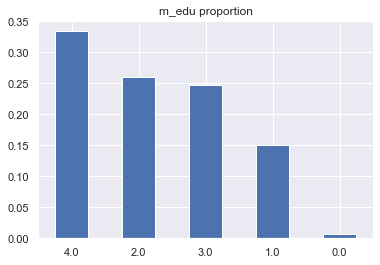

In [23]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'm_edu'

# Оценим состав данной колонки
print('Состав колонки', column)
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

# Имеются ли None-элементы или пробельные пропуски
nulls_list = mod_eda.find_nulls(stud[column])
print('\n', nulls_list[0])

# Оценим процентное содержание пропусков
nulls_sum = nulls_list[1] + nulls_list[2]
if nulls_sum > 0:
    print(f'Доля пропусков от объёма выборки: {round(nulls_sum/stud_count_total*100, 1)}%')

# Построим распределение
stud[column].value_counts(normalize=True).plot(kind='bar',
                                            grid= True,
                                            title=column + " proportion",
                                            legend=False)
plt.xticks(rotation = 0) 

In [24]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
# Получение списка колонок для анализа (c удалением изучаемой колонки)
col_list = list(stud.columns)
col_list.remove(column)

# Вывод колонок, имеющих статистически значимую взаимосвязь
all_col = [] # Вывод всех данных для дополнительной обработки
col_depend = []
for sub_column in col_list:
    cur_res = mod_eda.get_col_depend(stud.reset_index(), column, sub_column, 'index')
    all_col.append(cur_res)
    if float(cur_res[1]) > 0: # Если есть взаимосвязь
        col_depend.append(cur_res[2])
print('\n'.join(col_depend))

Обнаружена статистически значимая связь между "school" и "m_edu",	 log10(alpha/p_value) = 4.312
Обнаружена статистически значимая связь между "sex" и "m_edu",	 log10(alpha/p_value) = 0.401
Обнаружена статистически значимая связь между "age" и "m_edu",	 log10(alpha/p_value) = 1.484
Обнаружена статистически значимая связь между "adress" и "m_edu",	 log10(alpha/p_value) = 1.818
Обнаружена статистически значимая связь между "famsize" и "m_edu",	 log10(alpha/p_value) = 0.18
Обнаружена статистически значимая связь между "p_status" и "m_edu",	 log10(alpha/p_value) = 0.872
Обнаружена статистически значимая связь между "f_edu" и "m_edu",	 log10(alpha/p_value) = 1.548
Обнаружена статистически значимая связь между "m_job" и "m_edu",	 log10(alpha/p_value) = 2.389
Обнаружена статистически значимая связь между "f_job" и "m_edu",	 log10(alpha/p_value) = 3.696
Обнаружена статистически значимая связь между "guardian" и "m_edu",	 log10(alpha/p_value) = 0.659
Обнаружена статистически значимая связь между

In [25]:
# Выведем колонки с наиболее сильной связью 
lt = []
for col in all_col:
    if float(col[1]) > 2:
        lt.append([col[1], col[0]])
df = pd.DataFrame(lt, columns=['log_frac','col_name'])
print('Колонки с наиболее сильной взаимосвязью')
display(df.sort_values(['log_frac'],ascending=False))

Колонки с наиболее сильной взаимосвязью


,log_frac,col_name
0,4.312,school
2,3.696,f_job
5,3.039,nursery
6,2.76,internet
3,2.751,failures
4,2.466,paid
1,2.389,m_job
7,2.224,score


Так как пропущенных значений всего 3, заполним пропуски вручную.

In [26]:
stud[stud[column].isna()]

,school,sex,age,adress,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
92,GP,F,16,U,LE3,T,NaN,1.0,other,other,home,father,1.0,2.0,0.0,yes,yes,no,no,yes,-6.0,yes,no,no,3.0,3.0,NaN,2.0,4.0,30.0
193,GP,M,16,R,GT3,A,NaN,3.0,services,services,reputation,mother,1.0,1.0,0.0,no,yes,no,yes,yes,-3.0,yes,yes,no,4.0,3.0,2.0,5.0,8.0,50.0
239,GP,M,18,U,GT3,T,NaN,2.0,other,services,reputation,father,1.0,2.0,1.0,no,no,no,no,yes,-6.0,no,NaN,NaN,5.0,5.0,4.0,2.0,0.0,0.0


Колонки "school" и "nursery", "paid" не подходят, так как все студенты с пропущенным материнским образованием имеют в них одинаковые значения.

In [27]:
# ОЦЕНКА ВЗАИМОСВЯЗИ МЕЖДУ ДВУМЯ КОЛОНКАМИ
sub_column = 'f_job'

# Рассмотрим распределение значений:
print(f'Распределение значений колонки {sub_column} по значениям колонки {column}')
display(pd.crosstab(stud[column],stud[sub_column],normalize='columns'))

# Какое количество строк с пропусками в обеих колонках
print('\nКоличество строк с пропусками в обеих колонках:', len(stud[(stud[column].isna())&(stud[sub_column].isna())]))

# Оценим состав среди None в изучаемой колонки
print('\nСостав для None-значений изучаемой колонки')
display(stud[stud[column].isna()][sub_column].value_counts(normalize=True))

# Повтор пропорции
print('\nПропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Распределение значений колонки f_job по значениям колонки m_edu


f_job,at_home,health,other,services,teacher
m_edu,,,,,
0.0,0.0625,0.000000,0.010204,0.00,0.000000
1.0,0.2500,0.066667,0.147959,0.19,0.034483
2.0,0.3750,0.266667,0.295918,0.25,0.034483
3.0,0.0625,0.200000,0.280612,0.26,0.068966
4.0,0.2500,0.466667,0.265306,0.30,0.862069



Количество строк с пропусками в обеих колонках: 0

Состав для None-значений изучаемой колонки


services    0.666667
other       0.333333
Name: f_job, dtype: float64


Пропорция изучаемой колонки


,total,proportion
4.0,131,0.334184
2.0,102,0.260204
3.0,97,0.247449
1.0,59,0.150510
0.0,3,0.007653


На основе анализа колонки 'f_job' было принято решения заполнить пропуски следующим образом:

In [28]:
def fillna_m_edu(row):
    if pd.isna(row['m_edu']):
        if row['f_job'] == 'other':
            return 2
        else:
            return 4
    return row['m_edu']


stud[column] = stud.apply(fillna_m_edu, axis=1)

Имеются ли пропуски: False    395
Name: m_edu, dtype: int64

Новая пропорция изучаемой колонки


,total,proportion
4,133,0.336709
2,103,0.260759
3,97,0.245570
1,59,0.149367
0,3,0.007595


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

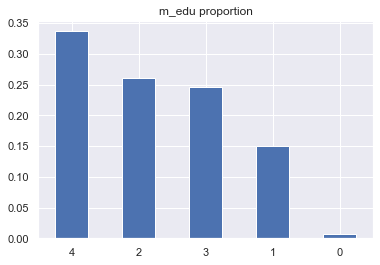

In [29]:
print('Имеются ли пропуски:', stud[column].isna().value_counts())

# После заполнения Nan превратим колонку в int
stud[column] = stud[column].astype(int)

# Оценим новый состав данной колонки
print('\nНовая пропорция изучаемой колонки')
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

# Построим распределение
stud[column].value_counts(normalize=True).plot(kind='bar',
                                            grid= True,
                                            title=column + " proportion",
                                            legend=False)
plt.xticks(rotation = 0) 

### f_edu
Образование отца: **0** - нет, **1** - 4 класса, **2** - 5-9 классы,
    **3** - среднее специальное или 11 классов, **4** - высшее

In [30]:
# ОЗНАКОМЛЕНИЕМ С СОСТАВОМ РАНГОВОЙ КОЛОНКИ
# Интересующая колонка
column = 'f_edu'

# Оценим состав данной колонки
print('Состав колонки', column)
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

Состав колонки f_edu


,total,proportion
2.0,106,0.285714
3.0,96,0.258760
4.0,88,0.237197
1.0,78,0.210243
0.0,2,0.005391
40.0,1,0.002695


Имеется значение несоответствующее заявленным категориям. Логично предположить, что это значение "4" с опечаткой, исправим его.

Состав колонки f_edu


,total,proportion
2.0,106,0.285714
3.0,96,0.258760
4.0,89,0.239892
1.0,78,0.210243
0.0,2,0.005391



 24 - количество none-значений. Пробельные пропуски отсутствуют.
Доля пропусков от объёма выборки: 6.1%


(array([0, 1, 2, 3, 4]), <a list of 5 Text xticklabel objects>)

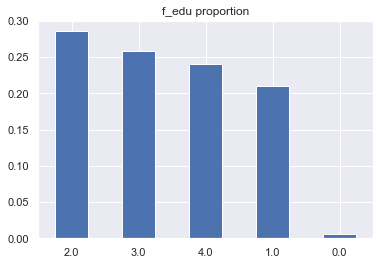

In [35]:
stud['f_edu'] = stud['f_edu'].replace(40, 4)

# Оценим состав данной колонки
print('Состав колонки', column)
display(pd.DataFrame({'total': stud[column].value_counts(), 
                      'proportion': stud[column].value_counts(normalize=True)}))

# Имеются ли None-элементы или пробельные пропуски
nulls_list = mod_eda.find_nulls(stud[column])
print('\n', nulls_list[0])

# Оценим процентное содержание пропусков
nulls_sum = nulls_list[1] + nulls_list[2]
if nulls_sum > 0:
    print(f'Доля пропусков от объёма выборки: {round(nulls_sum/stud_count_total*100, 1)}%')

# Построим распределение
stud[column].value_counts(normalize=True).plot(kind='bar',
                                            grid= True,
                                            title=column + " proportion",
                                            legend=False)
plt.xticks(rotation = 0) 

Найдём взаимосвязанные колонки

In [36]:
stud[stud[column].isna()]

,school,sex,age,adress,famsize,p_status,m_edu,f_edu,m_job,f_job,reason,guardian,traveltime,studytime,failures,schoolsup,famsup,paid,activities,nursery,studytime_granular,higher,internet,romantic,famrel,freetime,goout,health,absences,score
21,GP,M,15,U,GT3,T,4,NaN,health,health,other,father,1.0,1.0,NaN,no,yes,NaN,no,yes,-3.0,yes,yes,no,5.0,4.0,2.0,5.0,0.0,75.0
42,GP,M,15,U,GT3,T,4,NaN,services,teacher,course,father,1.0,2.0,0.0,no,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,3.0,5.0,2.0,90.0
46,GP,F,16,U,LE3,A,3,NaN,other,services,home,mother,1.0,2.0,0.0,no,yes,no,no,yes,-6.0,yes,yes,no,2.0,3.0,5.0,3.0,12.0,55.0
57,GP,M,15,U,GT3,T,4,NaN,teacher,health,reputation,mother,1.0,2.0,0.0,no,yes,NaN,yes,yes,-6.0,yes,no,no,3.0,2.0,2.0,5.0,4.0,75.0
58,GP,M,15,U,LE3,T,1,NaN,other,at_home,home,father,1.0,2.0,0.0,yes,yes,no,yes,yes,-6.0,yes,yes,no,4.0,3.0,2.0,5.0,2.0,45.0
67,GP,F,16,U,GT3,T,3,NaN,services,other,course,mother,1.0,4.0,0.0,yes,yes,yes,no,yes,-12.0,yes,yes,NaN,4.0,3.0,3.0,5.0,4.0,30.0
137,GP,F,16,U,GT3,A,3,NaN,other,other,NaN,other,NaN,1.0,2.0,no,yes,no,yes,no,-3.0,yes,yes,yes,4.0,3.0,2.0,5.0,0.0,0.0
142,GP,F,15,U,GT3,T,4,NaN,teacher,services,course,mother,NaN,3.0,0.0,no,yes,yes,yes,yes,-9.0,NaN,yes,no,4.0,2.0,2.0,5.0,2.0,55.0
159,GP,M,16,U,GT3,T,3,NaN,other,services,course,father,1.0,2.0,1.0,no,yes,yes,no,yes,-6.0,yes,yes,yes,4.0,5.0,5.0,5.0,4.0,60.0
161,GP,M,15,R,GT3,T,3,NaN,other,NaN,course,mother,2.0,2.0,2.0,yes,yes,no,no,yes,-6.0,yes,yes,yes,4.0,4.0,4.0,3.0,6.0,35.0


In [32]:
# ПОИСК СВЯЗАННЫХ КОЛОНОК
# Получение списка колонок для анализа (c удалением изучаемой колонки)
col_list = list(stud.columns)
col_list.remove(column)

# Вывод колонок, имеющих статистически значимую взаимосвязь
all_col = [] # Вывод всех данных для дополнительной обработки
col_depend = []
for sub_column in col_list:
    cur_res = mod_eda.get_col_depend(stud.reset_index(), column, sub_column, 'index')
    all_col.append(cur_res)
    if float(cur_res[1]) > 0: # Если есть взаимосвязь
        col_depend.append(cur_res[2])
print('\n'.join(col_depend))

KeyError: '[0.0] not in index'